# Notebook 2 - Design of inhibitors against histamine H1 receptor

By Vincent Blay, June 2021

In this notebook, we demonstrate the use of MACAW embeddings to model binding affinity to a protein receptor of pharmacological interest. MACAW embeddings are then applied to identify promising candidate molecules in a custom virtual library.

In [1]:
pwd

'C:\\Users\\Enka\\Desktop\\LDRD\\macaw_repo\\notebooks'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.svm import SVR
from sklearn_rvm import EMRVR

#Needed to show molecules
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole 

import macaw_py
print(macaw_py.__version__)
from macaw_py import *

%run "./plotting.py"

0.1.8


## 1. Binding to histamine H1 receptor

### 1.1 Data preparation

In [3]:
df = pd.read_csv("../data/data_H1.csv")
Y = df.pKi
smiles = df.Smiles
df.head()

,ID,compound_id,Smiles,pKi
0,1,CHEMBL3925977,O=C(O)c1ccc2cccnc2c1N1CCN(CCc2ccc(OCCCN3CCCCCC...,5.599999
1,2,CHEMBL2171045,O=C(NS(=O)(=O)c1cccc(C(F)(F)F)c1)N1CCC(N2CCC(O...,7.400008
2,3,CHEMBL3753784,COc1ccc(CNc2nc(N3CCN(C)CC3)nc3c2CCc2ccccc2-3)c...,5.200000
3,4,CHEMBL3917794,O=C(O)c1ccc2cccc(N3CCN(CCc4ccc(OCCCN5CCCCCC5)c...,6.599998
4,5,CHEMBL240394,O=C(c1cc(F)cc(F)c1)N1CCN(c2ccc(OCCCN3CCCCC3)cc...,5.700001


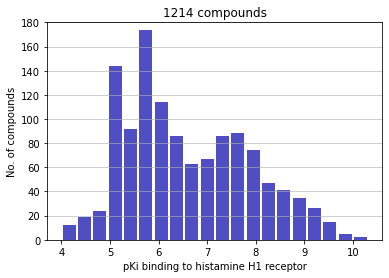

In [4]:
plot_histogram(Y, xlabel="pKi binding to histamine H1 receptor")

In [5]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size=0.2, random_state=42)

### 1.2 Compute MACAW embeddings

In [6]:
mcw = MACAW_optimus(smi_train, y=y_train, verbose=True, C=10)
#mcw = MACAW(type_fp='atompairs', metric='sokal',n_components=15)

Problem type identified as regression
morgan2 + tanimoto: 0.523
morgan3 + tanimoto: 0.528
rdk5 + tanimoto: 0.557
rdk7 + tanimoto: 0.555
featmorgan2 + tanimoto: 0.549
featmorgan3 + tanimoto: 0.564
maccs + tanimoto: 0.478
avalon + tanimoto: 0.593
atompairs + tanimoto: 0.551
torsion + tanimoto: 0.482
pattern + tanimoto: 0.605
secfp6 + tanimoto: 0.502
layered + tanimoto: 0.602
avalon + cosine: 0.588
avalon + dice: 0.585
avalon + sokal: 0.575
avalon + kulczynski: 0.574
avalon + mcconnaughey: 0.574
avalon + braun-blanquet: 0.602
avalon + rogot-goldberg: 0.593
avalon + asymmetric: 0.585
avalon + manhattan: 0.584
pattern + cosine: 0.584
pattern + dice: 0.565
pattern + sokal: 0.623
pattern + kulczynski: 0.586
pattern + mcconnaughey: 0.586
pattern + braun-blanquet: 0.506
pattern + rogot-goldberg: 0.568
pattern + asymmetric: 0.611
pattern + manhattan: 0.544
layered + cosine: 0.606
layered + dice: 0.605
layered + sokal: 0.599
layered + kulczynski: 0.590
layered + mcconnaughey: 0.590
layered + brau

In [31]:
mcw = MACAW(type_fp='atompairs', metric='sokal', n_components=15)
mcw.fit(smi_train)

In [33]:
X_train = mcw.transform(smi_train)
X_train.shape

(971, 15)

In [34]:
X_test = mcw.transform(smi_test)
X_test.shape

(243, 15)

### 1.3 Modeling using a SVR

In [10]:
for C in [1,3,5,7,10,30,50]:
    regr = SVR(kernel='rbf', C=C, epsilon=.3)
 
    scores = cross_val_score(regr, X_train, y_train, cv = 5)
    print(scores.mean())

0.6815950482967909
0.6934124793891876
0.6986480922926546
0.6989065508884014
0.6978201397208116
0.6868467072599966
0.6737996697804329


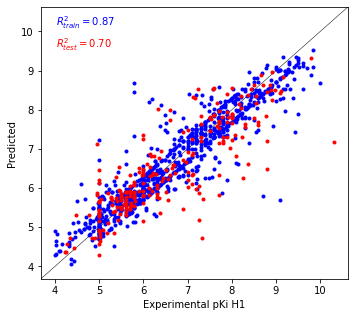

In [11]:
regr = SVR(kernel='rbf', C=10, epsilon=.3)
regr.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr.predict(X_train)

# Test set predictions
y_test_pred = regr.predict(X_test)

# Parity plot
parity_plot(x=y_train,y=y_train_pred,x_test=y_test,y_test=y_test_pred, 
            xlabel="Experimental pKi H1", savetitle="../results/H1_SVR.png") 

## 2. Binding to muscarinic receptor M2

### 2.1 Data preparation

In [3]:
df = pd.read_csv("../data/data_M2.csv")
Y = df.pKi
smiles = df.Smiles
df.head()

,ID,compound_id,Smiles,pKi
0,1,CHEMBL358493,C[N+]12CCC(CC1)C(O)(c1cc3ccccc3o1)C2,5.259637
1,2,CHEMBL343236,c1ccc2c(c1)CC(C1CN3CCC1CC3)O2,6.309894
2,3,CHEMBL150845,CC(=C1CCN(C2CCN(C(=O)c3ccc(F)c4ccccc34)CC2)CC1...,8.017729
3,4,CHEMBL593871,C[C@H]1OC[C@@H](C[N+](C)(C)C)O[C@@H]1C,4.780000
4,5,CHEMBL91404,CCOC(=O)N1CCC(N2CCC(C(=O)c3ccc(S(=O)(=O)c4ccc5...,9.886057


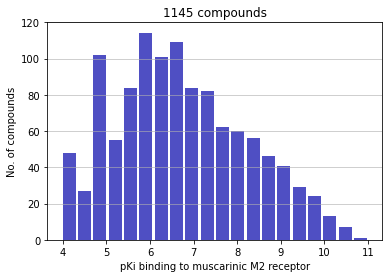

In [4]:
plot_histogram(Y, xlabel="pKi binding to muscarinic M2 receptor")

In [5]:
smi_train, smi_test, y_train, y_test = train_test_split(smiles, Y, test_size = 0.2, random_state = 42)

In [6]:
len(smi_train)

916

### 2.2 Compute MACAW embeddings

In [15]:
mcw2 = MACAW_optimus(smi_train, y= y_train, C=5, verbose=True, n_landmarks=200)
#mcw2 = MACAW(type_fp='atompairs', metric='rogot-goldberg')

Problem type identified as regression
morgan2 + tanimoto: 0.569
morgan3 + tanimoto: 0.587
rdk5 + tanimoto: 0.597
rdk7 + tanimoto: 0.590
featmorgan2 + tanimoto: 0.514
featmorgan3 + tanimoto: 0.559
maccs + tanimoto: 0.481
avalon + tanimoto: 0.563
atompairs + tanimoto: 0.626
torsion + tanimoto: 0.625
pattern + tanimoto: 0.562
secfp + tanimoto: 0.531
layered + tanimoto: 0.573
rdk5 + cosine: 0.607
rdk5 + dice: 0.615
rdk5 + sokal: 0.593
rdk5 + kulczynski: 0.596
rdk5 + mcconnaughey: 0.596
rdk5 + braun-blanquet: 0.583
rdk5 + rogot-goldberg: 0.621
rdk5 + asymmetric: 0.589
rdk5 + manhattan: 0.581
torsion + cosine: 0.613
torsion + dice: 0.616
torsion + kulczynski: 0.611
torsion + mcconnaughey: 0.611
torsion + braun-blanquet: 0.627
torsion + rogot-goldberg: 0.612
torsion + asymmetric: 0.601
torsion + manhattan: 0.583
atompairs + cosine: 0.616
atompairs + dice: 0.628
atompairs + sokal: 0.624
atompairs + kulczynski: 0.599
atompairs + mcconnaughey: 0.599
atompairs + braun-blanquet: 0.626
atompairs + 

In [16]:
X_train = mcw2.transform(smi_train)
print(X_train.shape)

X_test = mcw2.transform(smi_test)
print(X_test.shape)

(916, 15)
(229, 15)


### 2.3 Modeling using a SVR

In [17]:
for C in [1,3,5,10,30]:
    regr2 = SVR(kernel='rbf', C=C, epsilon=.5)
 
    scores = cross_val_score(regr2, X_train, y_train, cv = 5)
    print(scores.mean())

0.6784833085567896
0.7039528179667235
0.7100512810677193
0.7079396054975858
0.6936422093999142


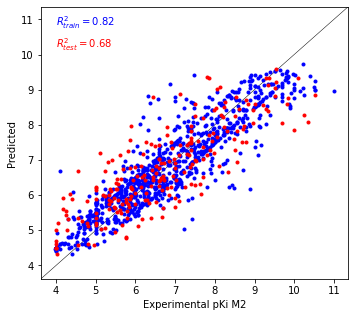

In [18]:
regr2 = SVR(kernel='rbf', C=5, epsilon=.5)
regr2.fit(X_train,y_train)

# Train set predictions
y_train_pred = regr2.predict(X_train)

# Test set predictions
y_test_pred = regr2.predict(X_test)

# Parity plot
parity_plot(x=y_train, y=y_train_pred, x_test=y_test, y_test=y_test_pred, 
            xlabel="Experimental pKi M2", savetitle="../results/M2_SVR.png")

## 3. Discovery of new hits specific to H1

In this section, we screen a custom virtual library looking for molecules that are promising accoring to the the SVR models `regr` and `regr2` above, which use 15-D MACAW embeddings as their input. The custom library ("LibraryVB.csv") is a custom library compiled from commercial catalogs by Enamine. In particular, we are interested in molecules with high predicted binding affinity to the H1 receptor and comparatively low predicted binding affinity to the M2 receptor.

In [19]:
mylib = pd.read_csv("../data/LibraryVB.csv")
print(mylib.shape)
mylib.head()

(19490, 2)


,Smiles,Source
0,NC(=O)NC(=O)Cn1c(=O)c(C#N)cn(C2CC2)c1=O,Enamine_antivirals
1,CC(C)CNC(=O)Cn1c(=O)c(C#N)cn(C2CC2)c1=O,Enamine_antivirals
2,O=C(Cn1cccnc1=O)NC1CCCCCC1,Enamine_antivirals
3,CCC(=O)Nc1ccc(cn1)N1CCOCC1,Enamine_antivirals
4,Cc1nn(C)c(C)c1CC(=O)NC(C1CC1)C1CC1,Enamine_antivirals


In [20]:
smi_lib = mylib.Smiles

In [21]:
X1_lib = mcw.transform(smi_lib)

Y1_lib_pred = regr.predict(X1_lib)

In [22]:
X2_lib = mcw2.transform(smi_lib)

Y2_lib_pred = regr2.predict(X2_lib)

Let us represent the predictions of both models:

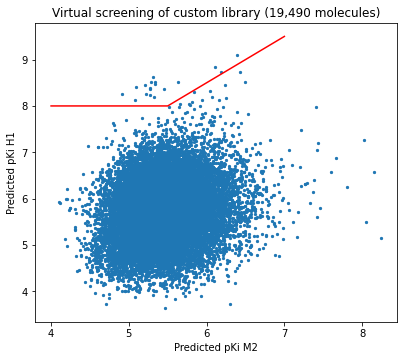

In [29]:
plt.figure(figsize=(6.5,5.5))
plt.scatter(x=Y2_lib_pred,y=Y1_lib_pred,s=5) 
plt.xlabel("Predicted pKi M2")
plt.ylabel("Predicted pKi H1")
plt.title("Virtual screening of custom library (19,490 molecules)")
plt.plot([4,5.5,7],[8,8,9.5],c='red')
plt.savefig("../results/H1_library_screening.png")

Let us have a look at the compounds:

In [30]:
indx = np.where((Y1_lib_pred > 8)*(Y1_lib_pred > (Y2_lib_pred + 2.5)))[0]

In [31]:
lead_df = mylib.iloc[indx].copy()
lead_df['pKi_H1_pred'] = Y1_lib_pred[indx]
lead_df['pKi_M2_pred'] = Y2_lib_pred[indx]

lead_df

,Smiles,Source,pKi_H1_pred,pKi_M2_pred
13946,CN(C)CC/C=C\1/c2ccccc2COc2ccccc12,Enamine_Phenotypic,9.088850,6.392342
13981,Oc1cccc(C=C2C(=O)Nc3ccccc23)c1,Enamine_Phenotypic,8.394391,5.275656
14978,CN(C)CC[C@@H](c1ccc(Cl)cc1)c1ccccn1,Enamine_Phenotypic,8.836779,6.104393
15018,Clc1ccc2NC(=O)C(=Cc3ccc(cc3)N3CCOCC3)c2c1,Enamine_Phenotypic,8.264368,5.223885
15028,CC(=O)Nc1ccc(C=C2C(=O)Nc3ccc(Cl)cc23)cc1,Enamine_Phenotypic,8.417513,5.094215
15087,Clc1ccc2NC(=O)C(=Cc3ccccc3)c2c1,Enamine_Phenotypic,8.525589,5.283025
15268,CC(C)c1ccc(C=C2C(=O)Nc3ccccc23)cc1,Enamine_Phenotypic,8.374095,5.452332
15328,CN(C)c1ccc(C=C2C(=O)Nc3ccccc23)cc1,Enamine_Phenotypic,8.259274,4.910106
17478,Fc1ccc(C=C2C(=O)Nc3ccccc23)cc1,Enamine_Phenotypic,8.466822,5.340368
17526,[O-][N+](=O)c1ccc(C=C2C(=O)Nc3ccccc23)cc1,Enamine_Phenotypic,8.506668,5.337182


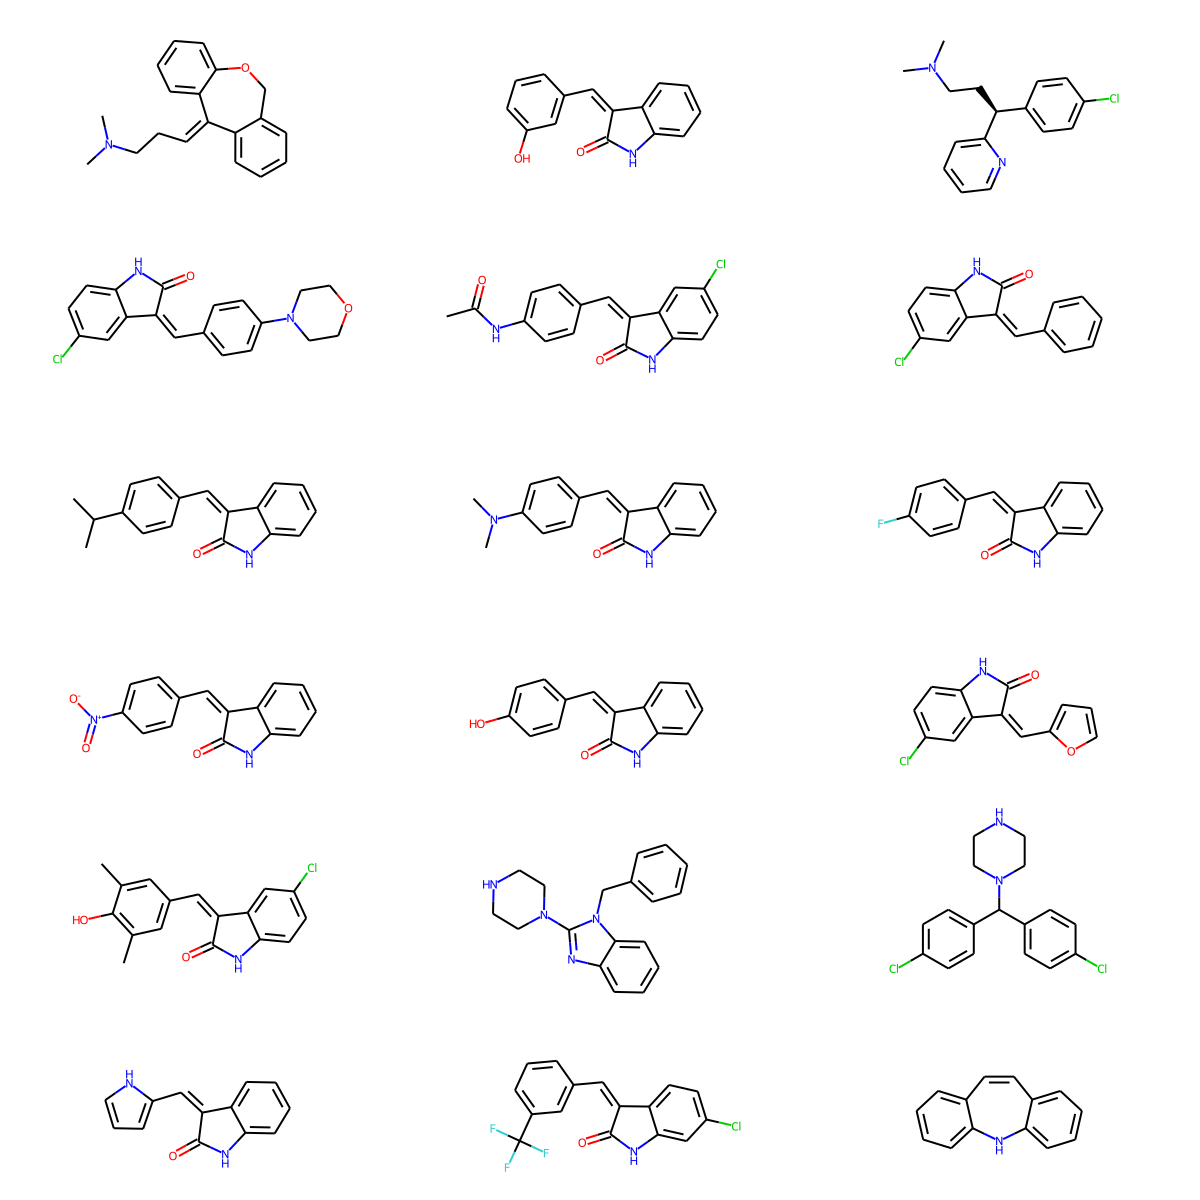

In [32]:
molecules = [Chem.MolFromSmiles(smi) for smi in lead_df.Smiles[:50]]

Draw.MolsToGridImage(molecules, subImgSize=(400,200))